# EE315 Audio Project
## Intro
This project involves playing with audio in order to determine what the Pynq Z2 board can do. It is used with two OLED displays and hardware incorporation.


![Intro Display](Images/intro.png)
<center>Figure 1: Intro Displayed on OLED</center>
 

Simulink was used to filter the audio that is recorded and streamed throguh the PYNQ board. The Vivado schematic for this is shown below.

![](Images/fir.png)
<center>Figure 2: Vivado Schematic</center>
    
Filters were implemented in Simulink and then passed through to Vivado for the Overlay to be created for the Pynq board. This is shwon being used in the 'Filtered Through High Pass Filter' section.



# OLED Readout 

This module of code sets up the two OLED displays and displays the opening screen on the first monitor and directions for use on the second screen. This provides illustration of data of the users choice.

In [2]:
from pynq.overlays.base import BaseOverlay 
#imports the base overlay to be used with the OLED
base = BaseOverlay("base.bit")

from pynq.lib.pmod import PMOD_GROVE_G4 
#import OLED Library

from pynq.lib.pmod import Grove_OLED
OLED = Grove_OLED(base.PMODB, PMOD_GROVE_G4) 
#first OLED definition
OLED2 = Grove_OLED(base.PMODA, PMOD_GROVE_G4) 
#second OLED definition
X = " o    \o/   _o_"
Y = "\n/|\    |    /\ "
Z = "\n/ \   / \   | \ \n"                 
#stickman dancing intro
Title ="EE315 Audio \n \t Project"
Title2 = "Please Continue \n \t in the  \n \t Jupyter Notebook \n "
OLED.write(X)
OLED.write(Y)
OLED.write(Z)
OLED.write(Title)

OLED2.write(Title2) 
#sets the intro and messages to display on their respective OLED displays

# Streaming Audio Through Board

This section of code allows audio to be fed through the board. It also allows two sliders to be produced and controlled; one for left channel and the second for right. The iteractive sliders operate by adjusting the audio files gain. This also means this overlay can be used in other functions in this program.

In [5]:
from pynq import Overlay
audioHW = Overlay('./Overlays/AudioGainsPL.bit') #imports the bitstream file for the overlay that can stream audio

?audioHW
pAudio = audioHW.audio_codec_ctrl_0 #these define ports within the overlay
gains = audioHW.audioprocessing_0
pAudio.select_line_in() #selects which port on the board to use

def setGains(Lch, Rch): #this is a function which writes the values to the overlay in a fucntion to save repeatedly calling it
    try:
        gains.write(0x0, int(Lch*10))  # left Channel
        gains.write(0x4, int(Rch*10))  # Right Channel
    except Exception: #this is a catch error incase unything unexpected happens
        import traceback
        print(traceback.format_exc())

def sliders():
    try:
        widgets.interact(setGains, Lch=LCH_Slider, Rch=RCH_Slider)#creates widgets within the jupyter file
    except Exception:
        import traceback #same as above, to catch any errors
        print(traceback.format_exc())
        
import ipywidgets as widgets #imports the library for widgets

LCH_Slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=1,
    step=0.1,
    description='Left Channel',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

RCH_Slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=1,
    step=0.1,
    description='Right Channel',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)#above two sections are definitions for the sliders and what values they contain, layout, step size etc

import _thread #allows multithreading - multiple streams of processing
outputLength = 60    # longest audio to be streamed is 60 seconds - limited by buffer size

try:
    _thread.start_new_thread(pAudio.bypass, (outputLength,)) #first process to control audio output
    _thread.start_new_thread(sliders, ()) #second process to control what happens when the sliders change value by the user
except Exception: #catch error
    import traceback
    print(traceback.format_exc())

# Reading Wav File

This module of code extracts data from a WAV file and allows it to be plotted in a matlab format. This module of code is adapted from within the files that are by default included with the PYNQ board.

In [1]:
%matplotlib inline 
import wave #imports wave library
import numpy as np #allows the use of arrays shortened to np in declarations
import matplotlib #imports matlab library
import matplotlib.pyplot as plt #imports mat lab plots shortened to plt in declarations
from scipy.fftpack import fft #imports fast fourier transform library shortened to fft in declarations

wav_path = "./Highwaytohell.wav" #file path to the wav file selected
with wave.open(wav_path, 'r') as wav_file: #this section of code allows various paramters to be read from the wave
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8) #the following two declarations are setting up arrays for the next sections of code
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8) 
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

# Displaying Amplitude Waveform (WAV Only)

For the number of channels that are present in the audio file, this module of code will display the audio waveform that is produced. This module of code is adapted from within the files that are by default included with the PYNQ board.

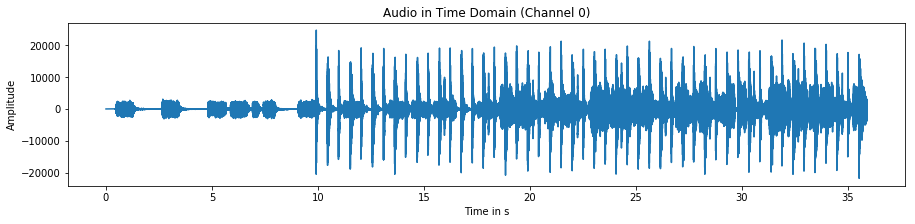

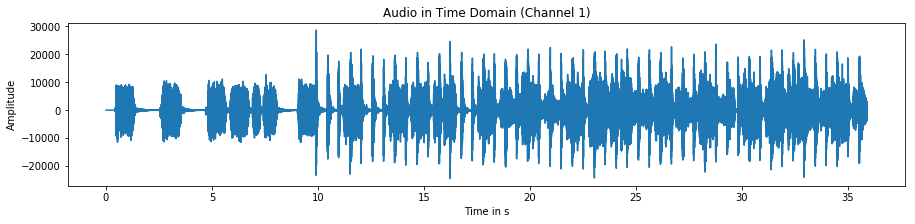

In [2]:
for channel_index in range(num_channels): #for the number of channels that are in the sound
    plt.figure(num=None, figsize=(15, 3)) #create a new figure
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))#label
    plt.xlabel('Time in s')#label
    plt.ylabel('Amplitude')#label
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate) #time axis that is scaled to array size
    plt.plot(time_axis, frames[:, channel_index]) #plot amplitude of the wav file extracted data
    plt.show() #show the figure to the user
    #plt.savefig('Awaveform.png', bbox_inches='tight') #save waveform created if wanted

# Reading WAV into Array 

This section reads the WAV file into an array and plots it. Only a small segmant of the full audio track is able to be used as it is limited by the buffer the board can handle. A full length song is too large so we are limited to around four seconds.

Number of samples:  200000


<IPython.core.display.Javascript object>


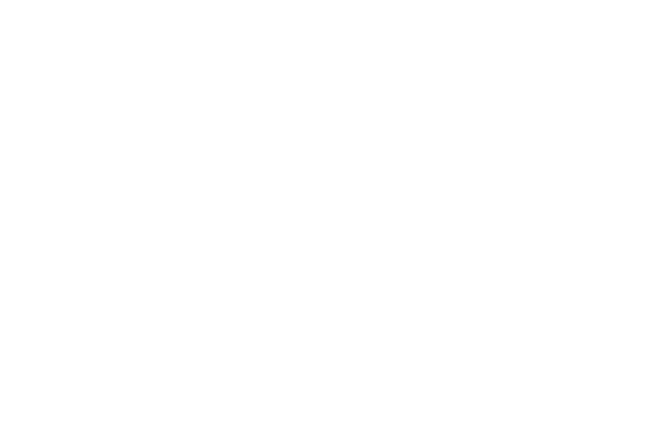

<IPython.core.display.Javascript object>


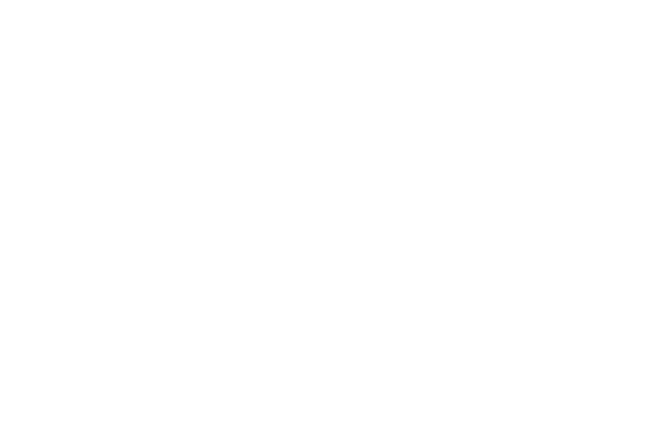

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None): #allows plots to be made easily as it will be reused in the following sections of code
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None: #ensures both signals can be placed on the same graph
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()
    
import numpy as np #allows use of arrays

# Total time
T = 0.002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
s = frames[:, channel_index]
samples = s[1200000:1400000]

# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,1000)

# Filtered Through High Pass Filter - Software

This section takes advantage of ways to implement software filtering. The execution time is also shown to allow it to be compared against the hardware filter that is implmented on the PYNQ board in a later module.

![](Images/fil.png)
<center>Figure 3: Created High Pass Filter</center>

This is the High Pass filter that was designed to filter the sound- the high pass filter is appropriate for the audio files chosen due to the nature of their sound. The filter was designed in the FDA tool within system generator and exported to MATLAB to get the filter coefficients listed below. Multiple coefficients are left in to show the effect this could have on the sound. Each array has different coefficients and therfore represents a different tyoe of filter(high, low and bandpass).

Software FIR execution time:  0.08804893493652344


<IPython.core.display.Javascript object>


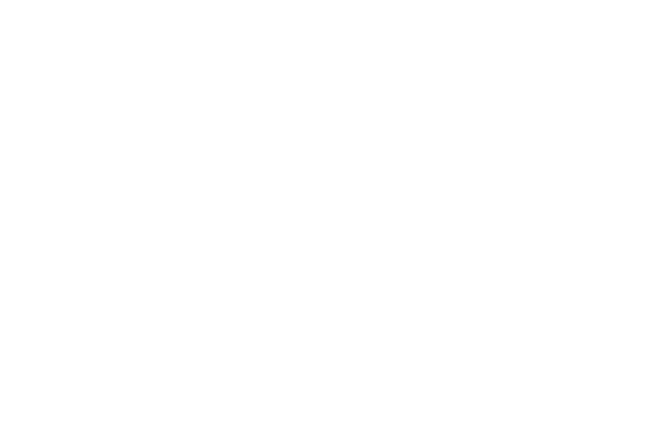

<IPython.core.display.Javascript object>


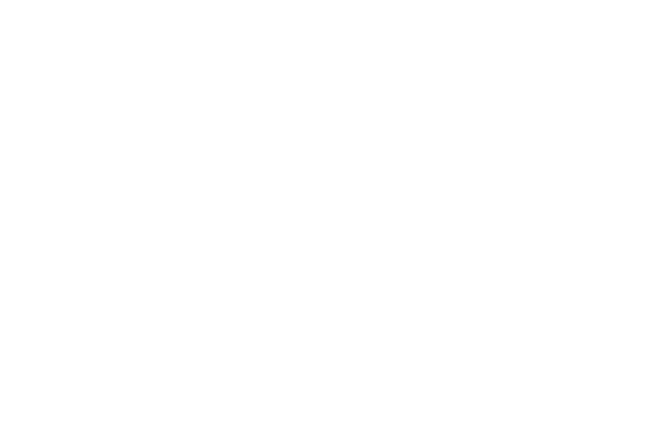

In [7]:
from scipy.signal import lfilter #allows software filter to be used

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]
#high pass
#coeffs = [16,9,-130,268,-382,344,-85,-329,671,-657,132,746,-1484,1443,-181,-2230,5125,-7484,8393,-7484,5125,-2230,-181,1443,-1484,746,132,-657,671,-329,-85,344,-382,268,-13]
#multiple coeffienct values to choose from to show how the filter can work and what the sound can behave like

import time #allows time to be a parameter
start_time = time.time()
sw_fir_output = lfilter(coeffs,70e3,samples) #software filter with coefficient values as a parameter
stop_time = time.time()
sw_exec_time = stop_time - start_time #this section is the execution time, starts a timer when it starts and triggers it again when it ends
print('Software FIR execution time: ',sw_exec_time)

# Plot the result to notebook
plot_to_notebook(t,samples,1000,out_signal=sw_fir_output)

# Loads the Custom Overlay 

This is the section that implements the filter at a hardware level in the form of a custom overlay. This configures the onboard hardware to be used with this specific application. The purpose of hardware utilisation to implement python functionality is hardware acceleration in the form of faster execution time.

In [5]:
from pynq import Overlay 
import pynq.lib.dma #allows the transfer between PS DRAM and PL

# Load the overlay
overlay = Overlay('./fir_accel.bit') #this is the custom overlay that contains the hardware ability for the filter

# Load the FIR DMA
dma = overlay.filter.fir_dma #this is the link between PS and PL that allows the transfer of the filtered sound(array)

# Filtered Through High Pass Filter - Hardware 

This is the section that combines the software elements and the hardware elements within the PYNQ board. It does this by passing the array to the DMA which acts as the link between the PS and PL sections of the board. The array that is passed out through the buffer is then reconstructed into a WAV file so that it can be played and it is possible to find out if the filtration was successful.

Hardware FIR execution time:  0.003676176071166992
Hardware acceleration factor:  20.600817173616967


<IPython.core.display.Javascript object>


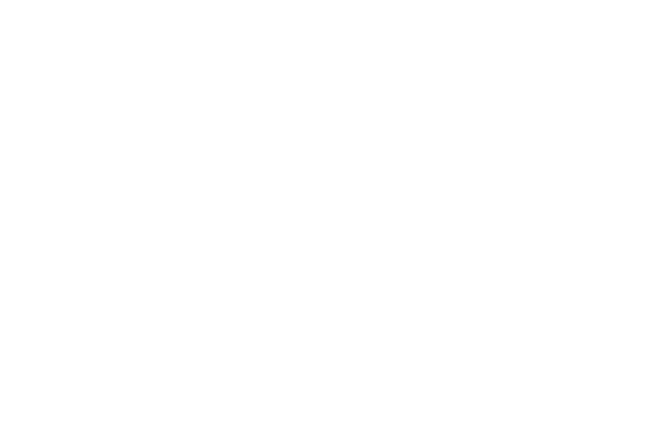

<IPython.core.display.Javascript object>


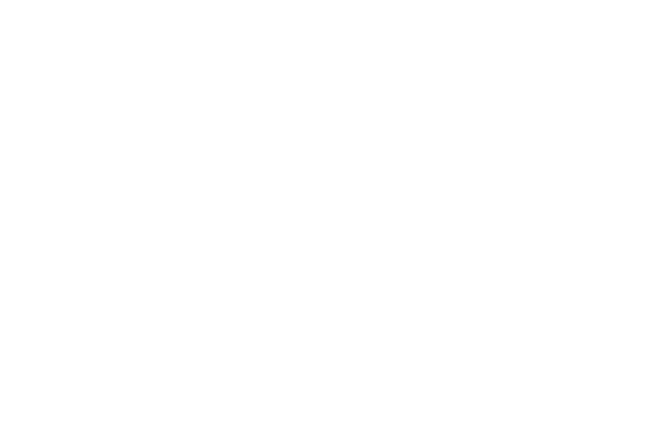

In [6]:
from pynq import Xlnk
import numpy as np

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time #works the same way as before with a timer
start_time = time.time()
dma.sendchannel.transfer(in_buffer) #starts transfer
dma.recvchannel.transfer(out_buffer) #receives transfer
dma.sendchannel.wait() #waits until data is passed through
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time) #time it takes for hardware execution
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time) #how much faster this is compared to the software 

# Plot to the notebook
plot_to_notebook(t,samples,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close() #closes buffer - memory reallocation

from scipy.io.wavfile import write
#this allows the array to be converted back to a wav file
scaled = np.int16(samples/np.max(np.abs(samples)) * 32767)
write('test.wav', 44100, scaled)
#the file is saved as it cannot be played straight away as the overlay has changed
#This overlay does not support playing audio

# Displaying Frequency Spectrum (WAV Only)

This functions in the same way as the module above but the frequency spectrum is shown. It can be seen that there are a lot of low frequency signals if the recording is directly used in this module. This is the interference in the signal, this is removed by using the filter in the modules of code below.

<IPython.core.display.Javascript object>


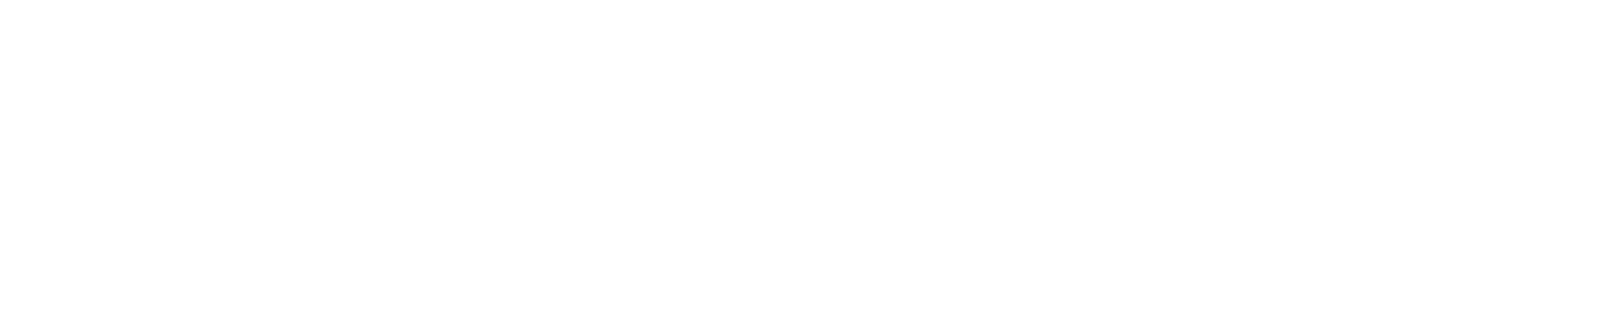

<IPython.core.display.Javascript object>


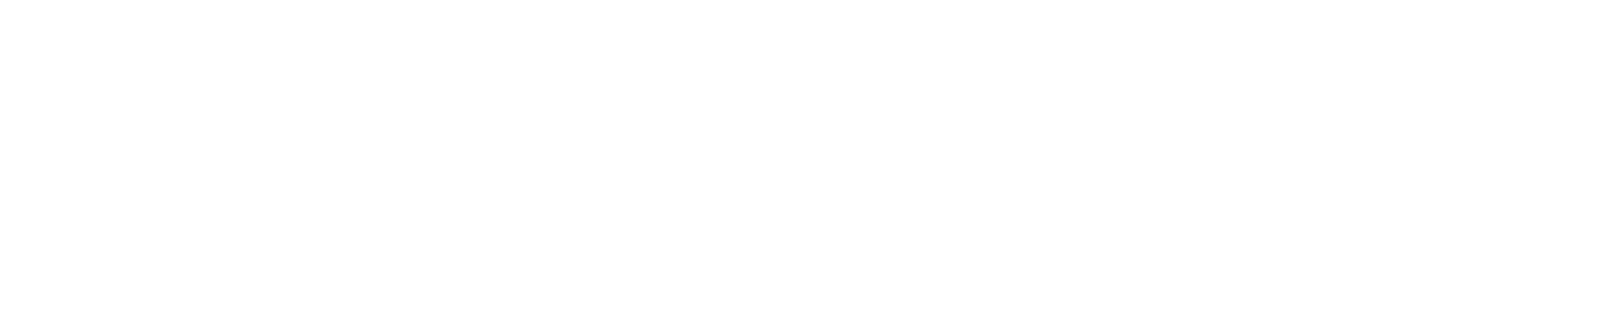

<IPython.core.display.Javascript object>


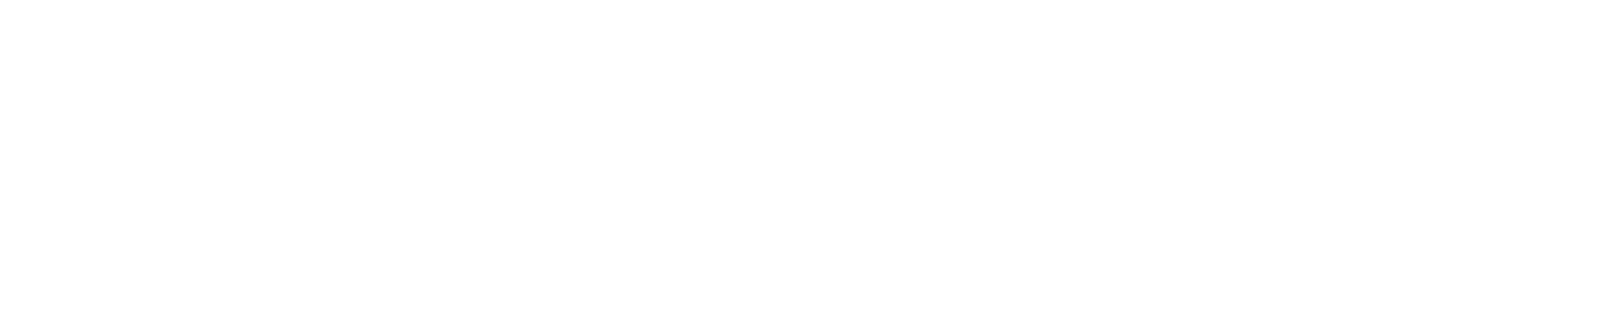

<IPython.core.display.Javascript object>


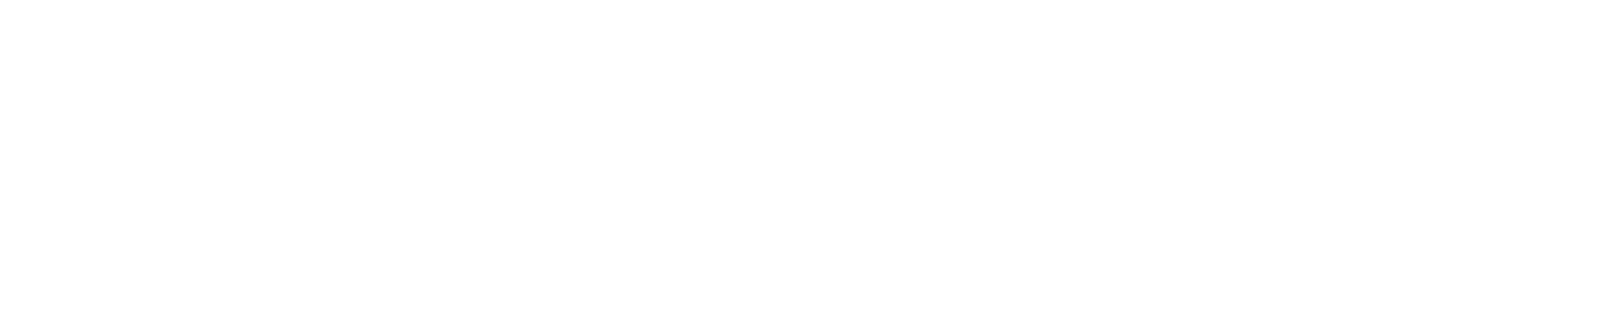

In [13]:
for channel_index in range(num_channels):#for the number of channels that are in the sound
    plt.figure(num=None, figsize=(15, 3))#create a new figure
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))#label
    plt.xlabel('Frequency in Hz')#label
    plt.ylabel('Magnitude')#label
    temp = fft(frames[:, channel_index])#fourier transform of the array used for amplitude waveform
    yf = temp[1:len(temp)//2]#scale the array to a useable size
    xf = np.linspace(0.0, sample_rate/2, len(yf))#frequency scale
    plt.plot(xf, abs(yf))#plot the values, absolute values used for magnitude
    plt.show() #show the figure to the user
    #plt.savefig('Fspectrum.png', bbox_inches='tight') #save waveform created if wanted

# Displaying Volume Via LED Light Bar

This section of code is used to display the volume to the user via the LED bars that are attached via the grove adapters to the ZYNQ board. The libraries for the LED bar are included with the ZYNQ board out of the box. The given overlay for audio streaming and channel adjustment has been altered to allow for a slider for volume that can be adjusted.

In [14]:
from pynq.overlays.base import BaseOverlay 
base1 = BaseOverlay("base.bit") #imports the base overlay
from pynq.lib.pmod import PMOD_GROVE_G3 # imports pmod for grove place

from pynq.lib.pmod import Grove_LEDbar #imports library for LED bar
from time import sleep#allows waits to be used(sleep)
leftledbar = Grove_LEDbar(base1.PMODB,PMOD_GROVE_G3) #defines left LED bar
leftledbar.reset() #sets all outputs 0
rightledbar = Grove_LEDbar(base1.PMODA,PMOD_GROVE_G3) #defines right LED bar
rightledbar.reset() #sets all outputs 0

leftledbar.write_binary(0b1010100000) #left green, right red, sets values on or off 
sleep(0.5) #pause 0.5 seconds
rightledbar.write_binary(0b0101011111)
sleep(0.5)

# Buttons, Switches and LEDs UNDERWORK

This section contains the definitions for the buttons and switches on the board. They are used to control sound output selection. The intent with this section is that it can be set up with interupts to ensure operation whichever module of code is being used. This code is adapted from code already within the PYNQ directory.

In [15]:
from pynq.overlays.base import BaseOverlay #allows the base overlay to be used
base = BaseOverlay("base.bit")

# Set the number of Switches, LEDs and Buttons
MAX_LEDS = 4
MAX_SWITCHES = 2
MAX_BUTTONS = 4

leds = [base.leds[index] for index in range(MAX_LEDS)] #creates arrays to make controlling the inputs easier
switches = [base.switches[index] for index in range(MAX_SWITCHES)] 
buttons = [base.buttons[index] for index in range(MAX_BUTTONS)] 

# Create lists for each of the IO component groups
for i in range(MAX_LEDS):
    leds[i] = base.leds[i]              
for i in range(MAX_SWITCHES):
    switches[i] = base.switches[i]      
for i in range(MAX_BUTTONS):
    buttons[i] = base.buttons[i]
    
# LEDs start in the off state 
for i in range(MAX_LEDS):
    leds[i].off()
    
# if a slide-switch is on, the corresponding LED should be switched on
# concurrently with it
for i in range(MAX_LEDS):
    if switches [i%2].read():
        leds[i].on()
    else:
        leds[i].off()
        
#int i = 1    #section of code to allow the LEDs to be toggled on or off
#while i > 0
#for i in range(MAX_LEDS):
#    if buttons[i].read():
#        leds[i].toggle()

#    if buttons[i].read():
#        leds[i].toggle()  

#import asyncio #fake multithreading allows multiple operations

#@asyncio.coroutine
#def flash_led(num):
#    while True:
#        yield from base.buttons[num].wait_for_value_async(1)
#        while base.buttons[num].read():
#            base.leds[num].toggle()
#            yield from asyncio.sleep(0.1)
#        base.leds[num].off()

# Recording and Playing Back Audio

To record audio on the board one of the audio ports needs to be selected, in this case it is the HP+MIC port. This module of code records a 10 second clip of audio and saves it to allow it to be processed through filters in the following functions. The recording can be adjusted to user preference upto 60 seconds. A message is displayed on the OLED display to show when the sound is being recorded and when it is saved. An interactive element is also used in the Jupyter notebook to allow the recorded sound to be played on demand.

In [16]:
from pynq.overlays.base import BaseOverlay #imports the base overlay again as it was changed in the code sections above

#Plug Microphone into HP+MIC 
pAudio = base.audio #uses base overlay audio library to select output ports
pAudio.select_microphone() #selects microphone port
OLED.clear() #clears anything currently being display on the display
OLED.write("Recording") #displays to the OLED defined previously 
pAudio.record(10) #records audio
pAudio.save("recording_2.wav") #saves the recorded sound
OLED.clear()#clears anything currently being display on the display
OLED.write("Recording Saved")#outputs to OLED
OLED.clear()#clears anything currently being display on the display
pAudio.load("./recording_2.wav") #loads the recorded sound

pAudio.play() #plays the recorded sound

from IPython.display import Audio as IPAudio
IPAudio("Highwaytohell.wav") #this section of code uses a widget to play the file that is set in the file path

KeyboardInterrupt: 

# Info from Audio File (WAV or MP3)

This portion of code allows the external library 'TinyTag' to be used with WAV or MP3 files. This library strips the metadata from these files and allows it to be returned to the program. This could be the artist, genre album etc, it is then displayed on the OLED. This data is at the creaters discretion to include so it is not always present.

In [3]:
from tinytag import TinyTag #imports the library that can read metadata

tag = TinyTag.get('Highwaytohell.wav') #reads the metadate for the file that is at the end of the path
OLED.clear() #clears the display
OLED2.clear()
OLED.write('This track is by %s.' % tag.artist)#displays artists name
OLED.write('It is called %s.' % tag.title) #displays track name
OLED.write('\nIt is %f seconds long.' % tag.duration) #length of song
OLED.write('It is of the %s genre.' % tag.genre) #display genre

OLED2.write('Filesize:%s bits' % tag.filesize) #display filesize
OLED2.write('           Bitrate:%s' % tag.bitrate) #display bitrate
OLED2.write('Samplerate:%s Hz' % tag.samplerate) #display samplerate
OLED2.write('             %s' % tag.comment) #display message

from IPython.display import Audio as IPAudio
IPAudio("Highwaytohell.wav") #this section of code uses a widget to play the file that is set in the file path

# Lyrics for the Song

This module of code uses multiple libraries in order to search the internet for the lyrics for the songs provided. The libraries required are [3], [4], [5], [6]. It was not possible to implement this module due to many conflicts with BeautifulSoup4 - html parser. It felt as if it was close so the code that has been written for it so far has been left in.

In [12]:
#from bs4 import BeautifulSoup
import
from bs4 import BeautifulSoup

albums = PyLyrics.getAlbums(singer='Eminem')
myalbum = albums[4] #Select your album based on Index

tracks = myalbum.tracks() #or PyLyrics.getTracks(myalbum)
for track in tracks:
    print (track) #Each track is a track object
    print (track.getLyrics()) #Get the lyrics
    
print(PyLyrics.getLyrics('Taylor Swift','Blank Space')) #Print the lyrics directly   

ModuleNotFoundError: No module named 'bs4'

## References

[1] TinyTag <br> https://pypi.org/project/tinytag/

[2] FIR Filter <br> https://www.fpgadeveloper.com/2018/03/how-to-accelerate-a-python-function-with-pynq.html

[3] Beautiful Soup <br> https://www.crummy.com/software/BeautifulSoup/

[4] PyLyrics <br> https://pypi.org/project/PyLyrics/

[5] LyricMaster <br> https://pypi.org/project/lyricsmaster/

[6] LyricWikia <br> https://pypi.org/project/lyricwikia/